<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/vit_50epoch_apple_D_v_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [13]:
kid = KernelInceptionDistance(subset_size=6)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)#32
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)#64
parser.add_argument("--nch_d", type = int, default=64)#64
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=50, nch_d=64, nch_g=64, z_dim=100)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        #self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        self.file_list = glob.glob("/content/drive/MyDrive/Test/Apple**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()
         

    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z) 
        z = self.relu(z)

        z = self.conv2(z) 
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 \n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels) \n        self.bn =

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding 
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding \n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)
        
      
    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        
        identity = x#入力
        x = self.pre_bn(x)
       # x = self.se_block_0(x)
        x = self.attention(x) - x
        x = x + identity
        

        identity = x#入力
        x = self.pre_bn(x)
        b, c, h, w = x.size()
        x = self.conv1(x) 

        #print(x.size())
       # x = self.linear_1(x).view(b, -1, h, w)
        #print(x.size())
        x = self.relu(x)
        #x = self.linear_2(x).view(b, -1, h, w)
        #print(x.size())


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)
        
        return x 

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels 
        
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True)) 
        if se:
            layers.append(SE_G(out_channels)) 
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))
        


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)    

        out = self.vit3(out)
      
        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 67/67 [05:34<00:00,  4.99s/it]


epoch: 0, lossD:1.327667856394355, lossG:5.496198796514255,lossG_fake:2.454664977628793, lossG_real:3.04153382956092 ,equality:-0.586868851932127


/usr/local/lib/python3.7/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:38.462371826171875,kid_mean:0.013878772035241127, kid_std:0.01938825473189354,kid_:(tensor(0.0139), tensor(0.0194))


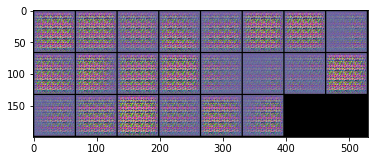

100%|██████████| 67/67 [00:37<00:00,  1.80it/s]


epoch: 1, lossD:0.33028681542891175, lossG:5.947768624149152,lossG_fake:2.4572450758805915, lossG_real:3.490523530476129 ,equality:-1.0332784545955374


evaluate:29.817346572875977,kid_mean:0.010080737993121147, kid_std:0.013140969909727573,kid_:(tensor(0.0101), tensor(0.0131))


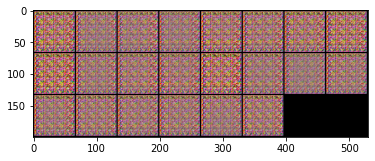

100%|██████████| 67/67 [00:37<00:00,  1.78it/s]


epoch: 2, lossD:0.35636549943418644, lossG:5.8752039795491235,lossG_fake:2.767185456717192, lossG_real:3.108018497922527 ,equality:-0.3408330412053351


evaluate:39.3839111328125,kid_mean:0.0174618698656559, kid_std:0.02835649996995926,kid_:(tensor(0.0175), tensor(0.0284))


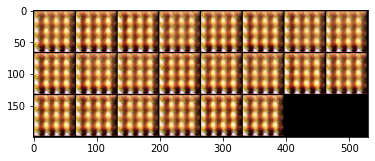

100%|██████████| 67/67 [00:37<00:00,  1.77it/s]


epoch: 3, lossD:0.5706806325200778, lossG:5.691273995299838,lossG_fake:3.045676505387719, lossG_real:2.645597500587577 ,equality:0.4000790048001419


evaluate:36.03962707519531,kid_mean:0.012406616471707821, kid_std:0.015049143694341183,kid_:(tensor(0.0124), tensor(0.0150))


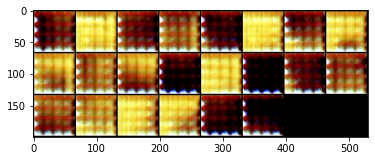

100%|██████████| 67/67 [00:38<00:00,  1.76it/s]


epoch: 4, lossD:0.4813563534572943, lossG:5.27913582502906,lossG_fake:2.8016816288677613, lossG_real:2.4774542459801063 ,equality:0.32422738288765496


evaluate:44.45293426513672,kid_mean:0.021984117105603218, kid_std:0.025851275771856308,kid_:(tensor(0.0220), tensor(0.0259))


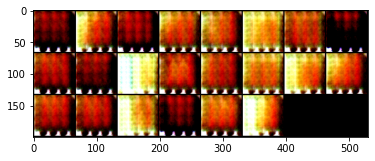

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 5, lossD:0.6333577599543244, lossG:5.0403996367952715,lossG_fake:2.661520392147463, lossG_real:2.3788792517647814 ,equality:0.2826411403826814


evaluate:41.09916687011719,kid_mean:0.017404796555638313, kid_std:0.021049926057457924,kid_:(tensor(0.0174), tensor(0.0210))


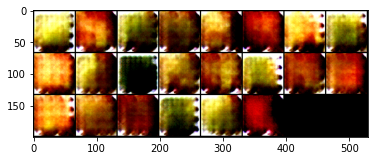

100%|██████████| 67/67 [00:38<00:00,  1.76it/s]


epoch: 6, lossD:0.7521458962070409, lossG:4.48761095573653,lossG_fake:2.332184843162992, lossG_real:2.1554261161320247 ,equality:0.1767587270309674


evaluate:38.854557037353516,kid_mean:0.019969122484326363, kid_std:0.024751659482717514,kid_:(tensor(0.0200), tensor(0.0248))


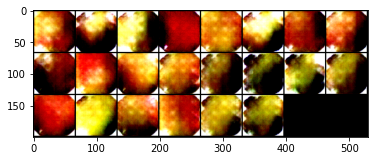

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 7, lossD:0.7721005349016902, lossG:4.332092274480791,lossG_fake:2.2394491380719996, lossG_real:2.092643124843711 ,equality:0.14680601322828846


evaluate:37.324745178222656,kid_mean:0.01238249521702528, kid_std:0.017812708392739296,kid_:(tensor(0.0124), tensor(0.0178))


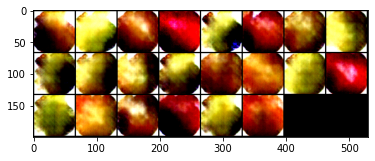

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 8, lossD:1.1192394488338213, lossG:3.8484927504809936,lossG_fake:2.0314991420774318, lossG_real:1.8169936052898863 ,equality:0.21450553678754547


evaluate:37.392818450927734,kid_mean:0.01518839318305254, kid_std:0.022532498463988304,kid_:(tensor(0.0152), tensor(0.0225))


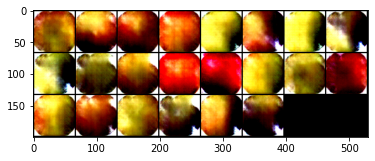

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 9, lossD:0.9465283564667204, lossG:4.108911037445068,lossG_fake:2.1702277722643384, lossG_real:1.9386832696288379 ,equality:0.23154450263550053


evaluate:39.219764709472656,kid_mean:0.016188059002161026, kid_std:0.02205638214945793,kid_:(tensor(0.0162), tensor(0.0221))


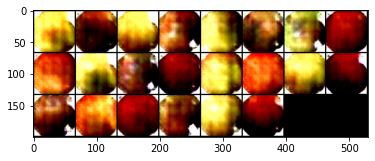

100%|██████████| 67/67 [00:38<00:00,  1.76it/s]


epoch: 10, lossD:1.0630549588310185, lossG:4.052512279197352,lossG_fake:2.1721587955062067, lossG_real:1.880353482356712 ,equality:0.29180531314949465


evaluate:38.8508186340332,kid_mean:0.015582957305014133, kid_std:0.021228643134236336,kid_:(tensor(0.0156), tensor(0.0212))


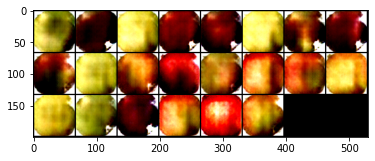

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 11, lossD:0.9402335248331526, lossG:4.148973486316738,lossG_fake:2.2122432491672575, lossG_real:1.9367302246947786 ,equality:0.27551302447247883


evaluate:40.90922546386719,kid_mean:0.01936289109289646, kid_std:0.024946050718426704,kid_:(tensor(0.0194), tensor(0.0249))


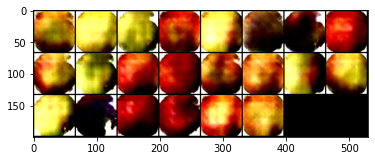

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 12, lossD:1.0232867340543377, lossG:4.259653119898554,lossG_fake:2.2237671204467317, lossG_real:2.03588599233485 ,equality:0.18788112811188196


evaluate:42.12166213989258,kid_mean:0.019156044349074364, kid_std:0.0264972485601902,kid_:(tensor(0.0192), tensor(0.0265))


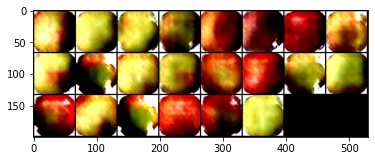

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 13, lossD:1.0117340799587875, lossG:4.171773910522461,lossG_fake:2.2042415880445225, lossG_real:1.9675323100232367 ,equality:0.23670927802128583


evaluate:39.64369583129883,kid_mean:0.013965311460196972, kid_std:0.022836100310087204,kid_:(tensor(0.0140), tensor(0.0228))


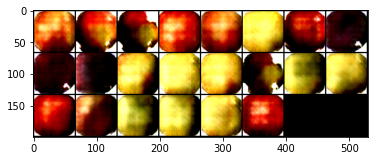

100%|██████████| 67/67 [00:38<00:00,  1.74it/s]


epoch: 14, lossD:1.0541899671305472, lossG:4.310758007106497,lossG_fake:2.2858539517246075, lossG_real:2.0249040580507534 ,equality:0.2609498936738541


evaluate:39.16398239135742,kid_mean:0.012242753058671951, kid_std:0.016292883083224297,kid_:(tensor(0.0122), tensor(0.0163))


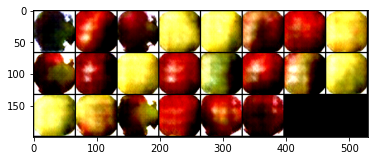

100%|██████████| 67/67 [00:38<00:00,  1.76it/s]


epoch: 15, lossD:1.0728413017828073, lossG:4.1703033020247275,lossG_fake:2.156972697421686, lossG_real:2.0133306090511494 ,equality:0.1436420883705365


evaluate:39.78300476074219,kid_mean:0.014269888401031494, kid_std:0.019190741702914238,kid_:(tensor(0.0143), tensor(0.0192))


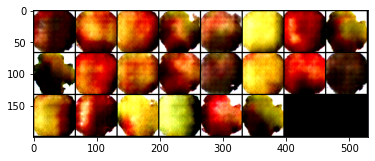

100%|██████████| 67/67 [00:38<00:00,  1.76it/s]


epoch: 16, lossD:0.9906519195481912, lossG:4.330958971336706,lossG_fake:2.2889488090330095, lossG_real:2.042010149848995 ,equality:0.2469386591840146


evaluate:42.597843170166016,kid_mean:0.01664452999830246, kid_std:0.018913740292191505,kid_:(tensor(0.0166), tensor(0.0189))


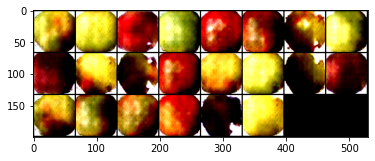

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 17, lossD:0.9623527601361275, lossG:4.585884119147685,lossG_fake:2.4181659577497796, lossG_real:2.167718164511581 ,equality:0.25044779323819855


evaluate:42.07258605957031,kid_mean:0.017949674278497696, kid_std:0.02704250067472458,kid_:(tensor(0.0179), tensor(0.0270))


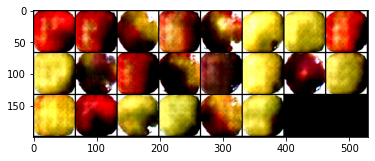

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 18, lossD:1.022790740007785, lossG:4.3552350143888106,lossG_fake:2.235108460508176, lossG_real:2.1201265394242843 ,equality:0.1149819210838916


evaluate:43.29178237915039,kid_mean:0.018809491768479347, kid_std:0.029358740895986557,kid_:(tensor(0.0188), tensor(0.0294))


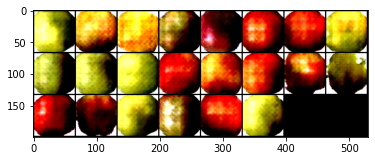

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 19, lossD:0.8807587783728072, lossG:4.694273820563929,lossG_fake:2.4522276689757163, lossG_real:2.242046164042914 ,equality:0.2101815049328022


evaluate:43.46438217163086,kid_mean:0.014614627696573734, kid_std:0.018921399489045143,kid_:(tensor(0.0146), tensor(0.0189))


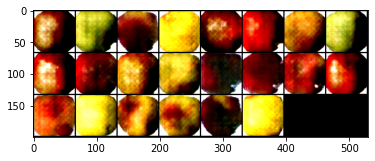

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 20, lossD:0.7297268271891039, lossG:4.909312614754064,lossG_fake:2.550904161894499, lossG_real:2.358408435067134 ,equality:0.19249572682736504


evaluate:44.41077423095703,kid_mean:0.015421552583575249, kid_std:0.021792251616716385,kid_:(tensor(0.0154), tensor(0.0218))


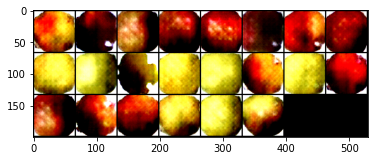

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 21, lossD:0.8187357242872466, lossG:4.973645573231711,lossG_fake:2.5727181278947575, lossG_real:2.400927468244709 ,equality:0.17179065965004847


evaluate:44.3453483581543,kid_mean:0.021404927596449852, kid_std:0.024064620956778526,kid_:(tensor(0.0214), tensor(0.0241))


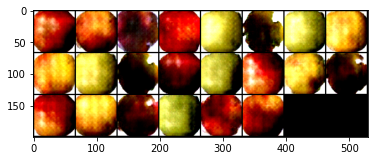

100%|██████████| 67/67 [00:38<00:00,  1.74it/s]


epoch: 22, lossD:0.7643991024858916, lossG:4.87203513330488,lossG_fake:2.467752648823297, lossG_real:2.4042824853712053 ,equality:0.06347016345209155


evaluate:42.981449127197266,kid_mean:0.018100382760167122, kid_std:0.02998840995132923,kid_:(tensor(0.0181), tensor(0.0300))


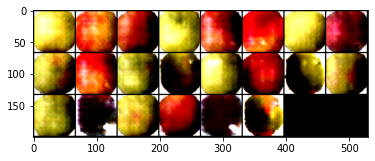

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 23, lossD:0.8218341701066316, lossG:5.0497363183035775,lossG_fake:2.57833226581118, lossG_real:2.471404039592885 ,equality:0.10692822621829468


evaluate:43.02193832397461,kid_mean:0.01595475524663925, kid_std:0.02101098746061325,kid_:(tensor(0.0160), tensor(0.0210))


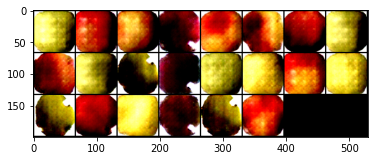

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 24, lossD:0.5905334033461204, lossG:5.205244292074175,lossG_fake:2.583915867022614, lossG_real:2.6213284134864807 ,equality:-0.037412546463866825


evaluate:42.95939636230469,kid_mean:0.017106985673308372, kid_std:0.025539463385939598,kid_:(tensor(0.0171), tensor(0.0255))


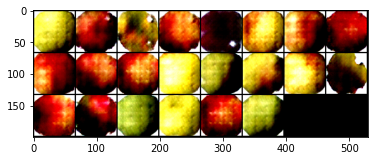

100%|██████████| 67/67 [00:38<00:00,  1.74it/s]


epoch: 25, lossD:0.7804465991125178, lossG:5.49131914395005,lossG_fake:2.8526514559539398, lossG_real:2.638667665922375 ,equality:0.21398379003156487


evaluate:43.460205078125,kid_mean:0.020169902592897415, kid_std:0.026495669037103653,kid_:(tensor(0.0202), tensor(0.0265))


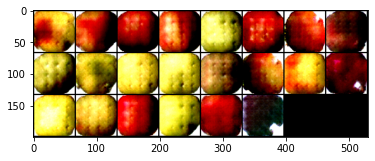

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 26, lossD:0.651061936059216, lossG:5.342601253025568,lossG_fake:2.7441116233370195, lossG_real:2.5984896215707507 ,equality:0.14562200176626883


evaluate:44.3063850402832,kid_mean:0.018607400357723236, kid_std:0.02459697611629963,kid_:(tensor(0.0186), tensor(0.0246))


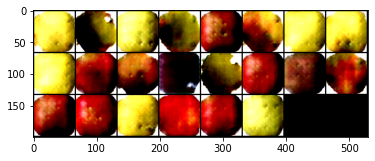

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 27, lossD:0.7244494991488198, lossG:5.162368838466815,lossG_fake:2.5584281896477314, lossG_real:2.6039406270789565 ,equality:-0.04551243743122502


evaluate:43.892032623291016,kid_mean:0.020384151488542557, kid_std:0.02567479945719242,kid_:(tensor(0.0204), tensor(0.0257))


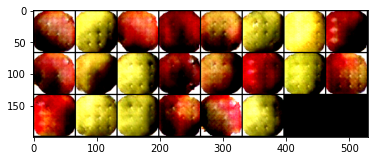

100%|██████████| 67/67 [00:38<00:00,  1.76it/s]


epoch: 28, lossD:0.49031056056438543, lossG:6.13795686123976,lossG_fake:2.9953977403356067, lossG_real:3.142559122683397 ,equality:-0.14716138234779041


evaluate:43.2404899597168,kid_mean:0.015026859939098358, kid_std:0.020211735740303993,kid_:(tensor(0.0150), tensor(0.0202))


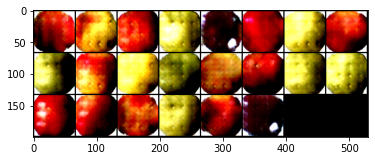

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 29, lossD:0.5722566597830894, lossG:5.779923994149735,lossG_fake:2.9497474534298056, lossG_real:2.83017655272982 ,equality:0.11957090069998566


evaluate:43.69259262084961,kid_mean:0.014322297647595406, kid_std:0.017191724851727486,kid_:(tensor(0.0143), tensor(0.0172))


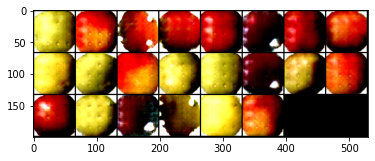

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 30, lossD:0.5748470919067735, lossG:5.759380020312409,lossG_fake:2.8639982493955696, lossG_real:2.8953817513451647 ,equality:-0.03138350194959516


evaluate:43.85914993286133,kid_mean:0.014024894684553146, kid_std:0.017855698242783546,kid_:(tensor(0.0140), tensor(0.0179))


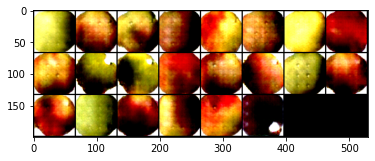

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 31, lossD:0.5884512632584838, lossG:5.40562088098099,lossG_fake:2.7483908907691044, lossG_real:2.657229972530657 ,equality:0.09116091823844741


evaluate:43.55852508544922,kid_mean:0.017856473103165627, kid_std:0.02309773676097393,kid_:(tensor(0.0179), tensor(0.0231))


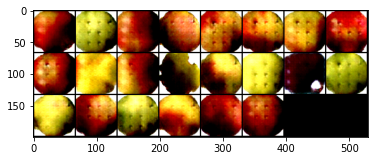

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 32, lossD:0.5316828405067547, lossG:5.967557309278801,lossG_fake:2.9197194887630977, lossG_real:3.047837838419338 ,equality:-0.12811834965624014


evaluate:44.1064453125,kid_mean:0.024016276001930237, kid_std:0.03145737573504448,kid_:(tensor(0.0240), tensor(0.0315))


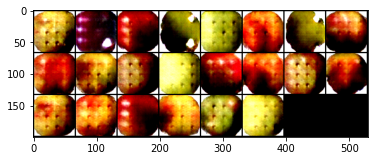

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 33, lossD:0.6284145281108012, lossG:5.587607426429862,lossG_fake:2.8549431480133713, lossG_real:2.732664283531815 ,equality:0.12227886448155623


evaluate:43.92723846435547,kid_mean:0.021716374903917313, kid_std:0.023521767929196358,kid_:(tensor(0.0217), tensor(0.0235))


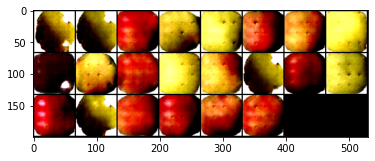

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 34, lossD:0.4827826147718327, lossG:5.980483233039059,lossG_fake:2.9652559041087305, lossG_real:3.0152273596222723 ,equality:-0.04997145551354176


evaluate:43.46219253540039,kid_mean:0.015955500304698944, kid_std:0.021039089187979698,kid_:(tensor(0.0160), tensor(0.0210))


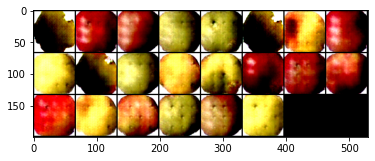

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 35, lossD:0.4439246809499255, lossG:6.223103210107604,lossG_fake:3.1058482821307964, lossG_real:3.117254941321131 ,equality:-0.011406659190334345


evaluate:43.67021942138672,kid_mean:0.02080194652080536, kid_std:0.02655026875436306,kid_:(tensor(0.0208), tensor(0.0266))


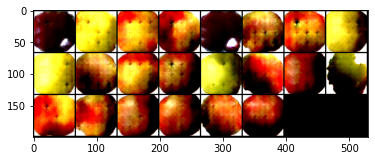

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 36, lossD:0.4158592300572947, lossG:6.22206270872657,lossG_fake:3.090983054308749, lossG_real:3.13107967376709 ,equality:-0.040096619458340754


evaluate:43.50257110595703,kid_mean:0.02260054647922516, kid_std:0.03087899461388588,kid_:(tensor(0.0226), tensor(0.0309))


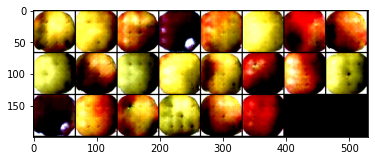

100%|██████████| 67/67 [00:38<00:00,  1.74it/s]


epoch: 37, lossD:0.47423499056708013, lossG:5.973595185066337,lossG_fake:2.987397297104793, lossG_real:2.986197886627112 ,equality:0.0011994104776809067


evaluate:43.11829376220703,kid_mean:0.016669563949108124, kid_std:0.024556266143918037,kid_:(tensor(0.0167), tensor(0.0246))


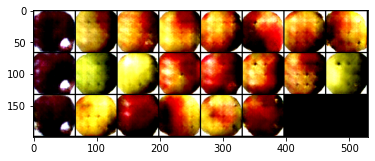

100%|██████████| 67/67 [00:38<00:00,  1.74it/s]


epoch: 38, lossD:0.45828170332112417, lossG:6.120184635048482,lossG_fake:3.1693185425516384, lossG_real:2.9508661195190986 ,equality:0.21845242303253976


evaluate:42.33831024169922,kid_mean:0.017530569806694984, kid_std:0.02202376164495945,kid_:(tensor(0.0175), tensor(0.0220))


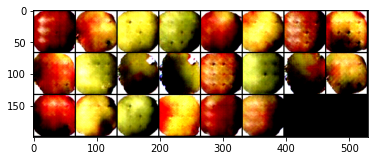

100%|██████████| 67/67 [00:38<00:00,  1.74it/s]


epoch: 39, lossD:0.32855418858243457, lossG:6.155147217992527,lossG_fake:3.14310142086513, lossG_real:3.0120458291537724 ,equality:0.1310555917113576


evaluate:41.859458923339844,kid_mean:0.020600145682692528, kid_std:0.029061611741781235,kid_:(tensor(0.0206), tensor(0.0291))


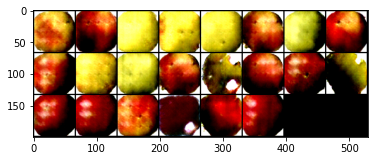

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 40, lossD:0.57567831636893, lossG:5.9323469133519415,lossG_fake:2.9384225042008643, lossG_real:2.9939244518529122 ,equality:-0.05550194765204797


evaluate:42.013572692871094,kid_mean:0.018051212653517723, kid_std:0.02691618725657463,kid_:(tensor(0.0181), tensor(0.0269))


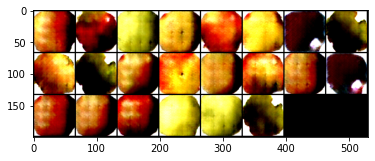

100%|██████████| 67/67 [00:38<00:00,  1.74it/s]


epoch: 41, lossD:0.2612994420064141, lossG:6.361693745228782,lossG_fake:3.198957322248772, lossG_real:3.162736436324333 ,equality:0.03622088592443928


evaluate:41.36762619018555,kid_mean:0.01877075992524624, kid_std:0.022587236016988754,kid_:(tensor(0.0188), tensor(0.0226))


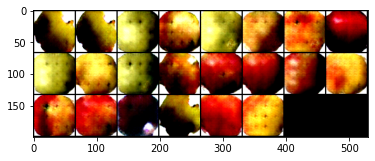

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 42, lossD:0.33837546550654873, lossG:6.4563152185126915,lossG_fake:3.2688371138786203, lossG_real:3.187478095737856 ,equality:0.0813590181407644


evaluate:41.10816192626953,kid_mean:0.01843095012009144, kid_std:0.024976279586553574,kid_:(tensor(0.0184), tensor(0.0250))


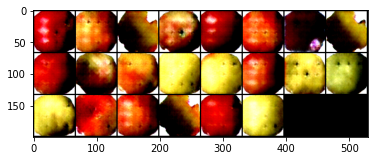

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 43, lossD:0.19784347897173085, lossG:6.548046788172935,lossG_fake:3.3253170981335995, lossG_real:3.2227296815879307 ,equality:0.10258741654566883


evaluate:41.1487922668457,kid_mean:0.013409819453954697, kid_std:0.019828660413622856,kid_:(tensor(0.0134), tensor(0.0198))


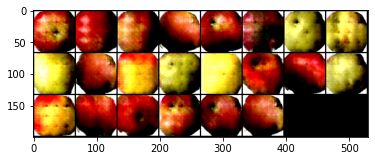

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 44, lossD:0.2467212259010134, lossG:6.694471864557978,lossG_fake:3.3079225002829706, lossG_real:3.3865493518203054 ,equality:-0.07862685153733473


evaluate:41.23820877075195,kid_mean:0.014309978112578392, kid_std:0.02113100327551365,kid_:(tensor(0.0143), tensor(0.0211))


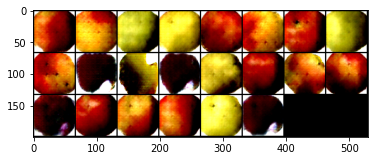

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 45, lossD:0.3103542955498447, lossG:6.900057059615405,lossG_fake:3.4621794766454554, lossG_real:3.437877573184113 ,equality:0.024301903461342533


evaluate:41.612667083740234,kid_mean:0.018944332376122475, kid_std:0.027118921279907227,kid_:(tensor(0.0189), tensor(0.0271))


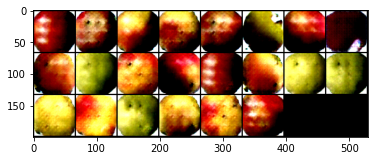

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 46, lossD:0.2548682846167167, lossG:7.026493570697841,lossG_fake:3.512516537709023, lossG_real:3.513977014028759 ,equality:-0.0014604763197363368


evaluate:41.37232971191406,kid_mean:0.013684799894690514, kid_std:0.020540157333016396,kid_:(tensor(0.0137), tensor(0.0205))


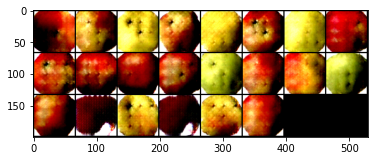

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 47, lossD:0.19414868686303025, lossG:7.631198335049757,lossG_fake:3.6544289313145537, lossG_real:3.9767694179691486 ,equality:-0.3223404866545949


evaluate:41.16184616088867,kid_mean:0.016134917736053467, kid_std:0.022407853975892067,kid_:(tensor(0.0161), tensor(0.0224))


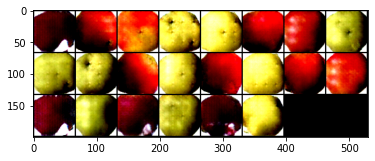

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 48, lossD:0.14457262044689104, lossG:7.535262648739032,lossG_fake:3.6590685546398163, lossG_real:3.876194080310081 ,equality:-0.21712552567026489


evaluate:40.902530670166016,kid_mean:0.01878366619348526, kid_std:0.026789331808686256,kid_:(tensor(0.0188), tensor(0.0268))


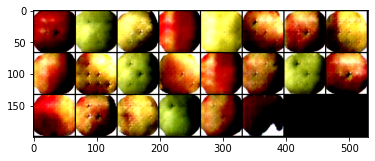

100%|██████████| 67/67 [00:38<00:00,  1.75it/s]


epoch: 49, lossD:0.33945326833923195, lossG:7.964613067570017,lossG_fake:3.9351654221762473, lossG_real:4.029447697659037 ,equality:-0.09428227548279011


evaluate:41.22752380371094,kid_mean:0.01695789024233818, kid_std:0.025917015969753265,kid_:(tensor(0.0170), tensor(0.0259))


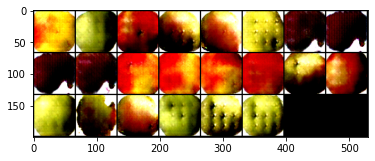

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality 
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

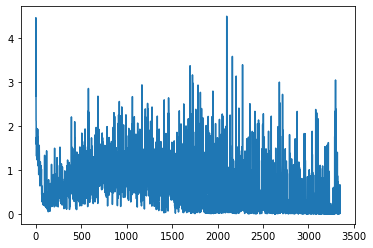

In [45]:
plt.plot(raw_lossesD)

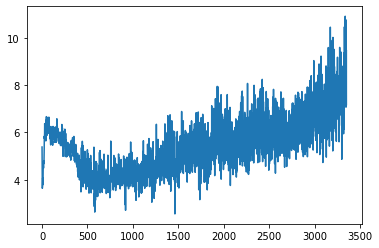

In [46]:
plt.plot(raw_lossesG)

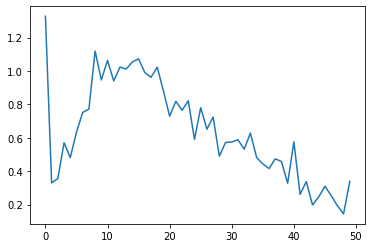

In [47]:
plt.plot(lossesD)

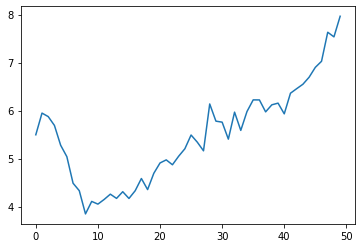

In [48]:
plt.plot(lossesG)

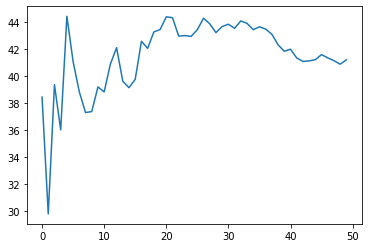

In [49]:
plt.plot(fid_)

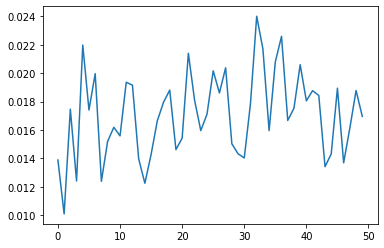

In [50]:
plt.plot(kid_mean_)

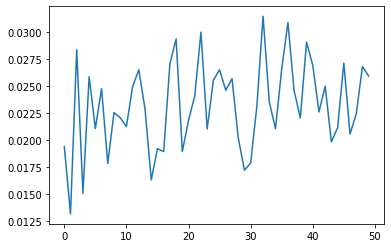

In [51]:
plt.plot(kid_std_)

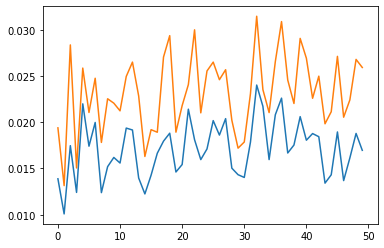

In [52]:
plt.plot(kid_score)

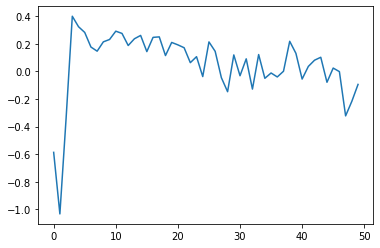

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0174), tensor(0.0213))